In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
# 1. 데이터 불러오기
file_path ="AmesHousing.csv"
df = pd.read_csv(file_path)

In [3]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

#결측치 출력
print("🕳️ 결측치가 있는 변수\n")
print(missing)

🕳️ 결측치가 있는 변수

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Electrical           1
dtype: int64


결측치에 대해서
1. 결측치가 있거나 없는것 자체가 중요한 정보가 될 수 있다. 예시로 위의 Pool QC는 2917개의 결측치로
    굉장히 많은 결측치가 있지만, Pool이 있는 집만이 결측치가 없을 가능성도 있다.
    따라서 이 정보를 Pool이 있고 없고로 활용할 수도 있을 것이다(정확한 해석은 확인해봐야 알 수 있다.)
2. 하지만 결측치가 5% 이하(이 데이터셋의 경우 약 146개)인 것은 무작위 결측으로 가정하고 평균이나 중앙값으로 대체하는 것이 타당한 경우가 많다.
    또한 결측 비율이 적은 경우 모델 성능에 큰 영향이 없는 경우가 많다고 판단할 수도 있다.
3. 그 이외의 결측치들의 경우는 여러 처리 방법 적용 이후 모델 성능을 통한 비교 or 데이터 탐색에 기반하여
    정당화 하는 것이 좋다. (논문을 근거로 삼는것이 가장 설득력 있다.) 
4. 1번에 이어서, 물론 80%이상(약 2344이상) 결측 비율이 매우 높고, 의미나 정보량이 부족한 경우 이를 근거로
    제거할 수 있을 것이다.
5. Garage에 대해서 Garage에 관련된 변수들의 결측치들의 개수가 거의 동일(Garage Type은 두개 부족)한것으로 보아 단순히 결측치를 채우는 것이 아닌, Garage의 유무에 대한 column도 만들면 좋을 것.

In [4]:
edited_df = df

#결측치 80%이상인경우 삭제
missing_cols = missing.loc[(missing / len(df)) > 0.80].index
edited_df = edited_df.drop(columns=missing_cols)

missing_cols = missing.loc[(missing / len(df)) < 0.05].index
for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        #결측치 5%이하 범주형 변수 최빈값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].mode().iloc[0])
    else:
        #결측치 5%이하 수치형 변수 중앙값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].median())
        
#1. 남은 결측치 전체 최빈값, 중앙값 대체
#2. 수치형은 MICE, 범주형은 'Missing'으로 결측치 채우기 -
#이외 다수..

#일단 2번방법
missing_cols = missing.loc[(0.05 <= (missing / len(df))) & ((missing / len(df)) <= 0.80)].index

numeric_cols = edited_df.select_dtypes(include=['number']).columns

for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        edited_df[col] = edited_df[col].fillna('Missing')

#MICE Imputation(다중 대체)이용하여 결측치 제거
imputer = IterativeImputer(random_state=0)
edited_df[numeric_cols] = imputer.fit_transform(edited_df[numeric_cols])


# 결측치가 남아있는 열이 있는지 확인
remaining_missing = edited_df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]


print(remaining_missing.head())

Series([], dtype: int64)


***단순선형회귀 및 시각화 부분***

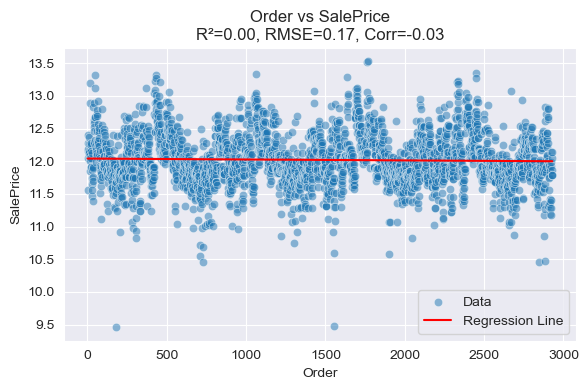

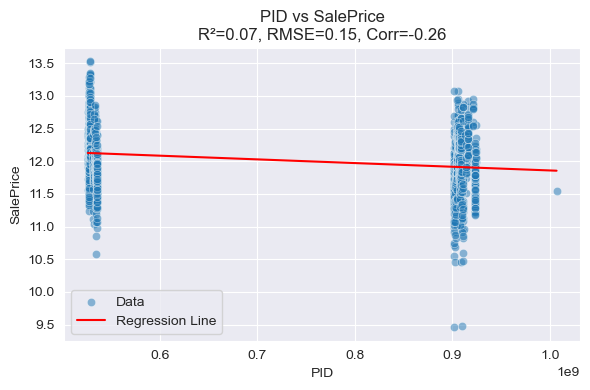

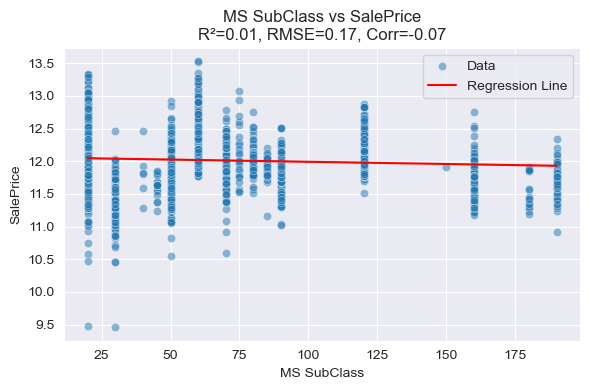

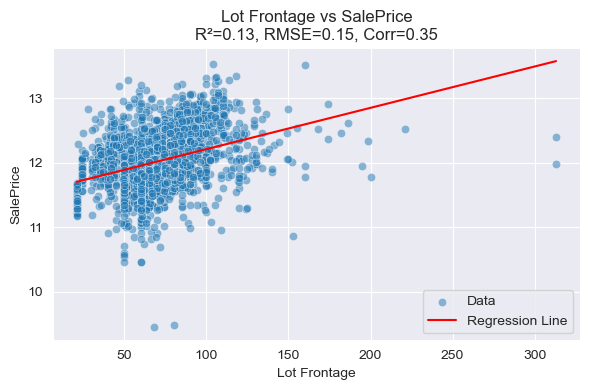

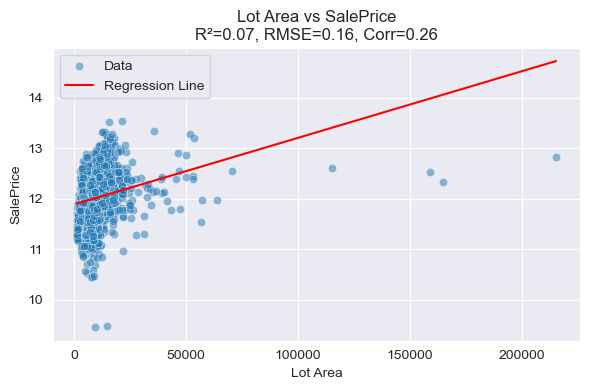

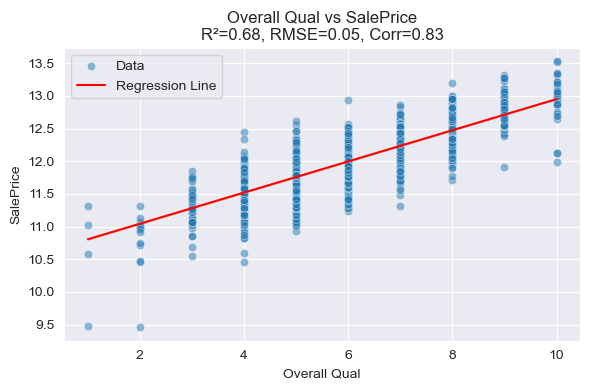

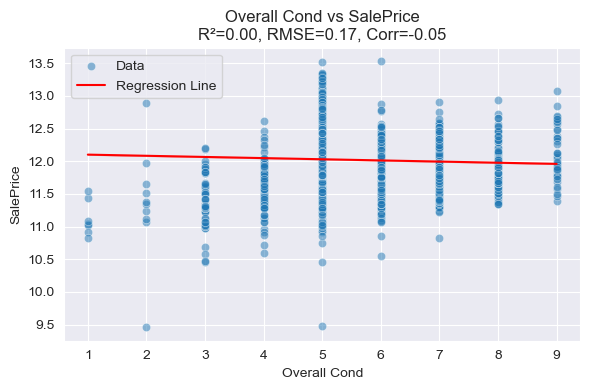

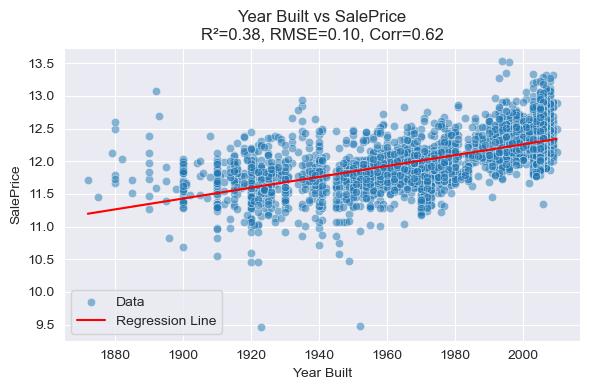

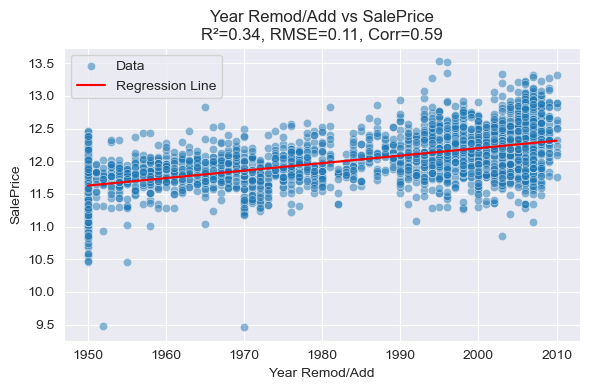

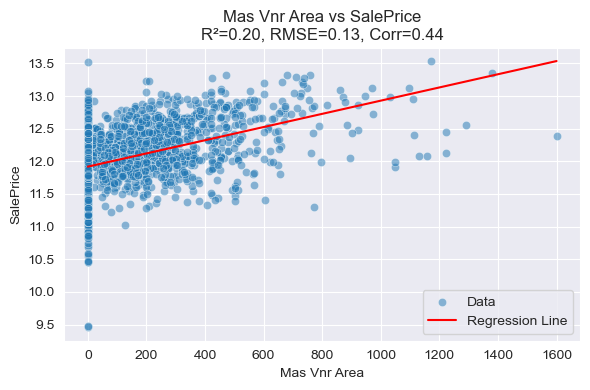

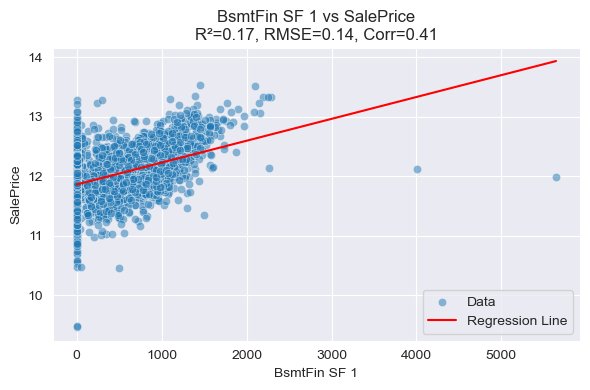

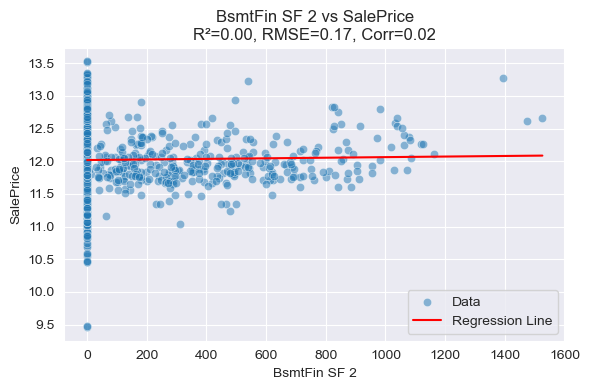

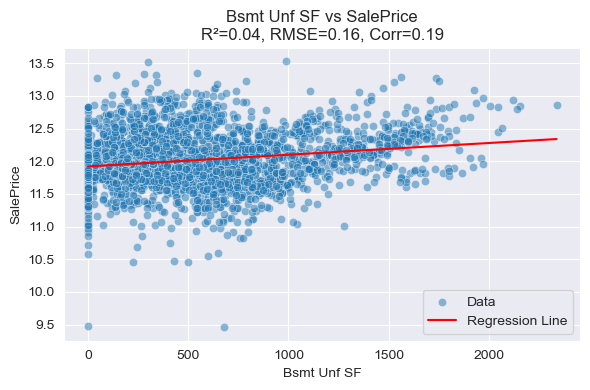

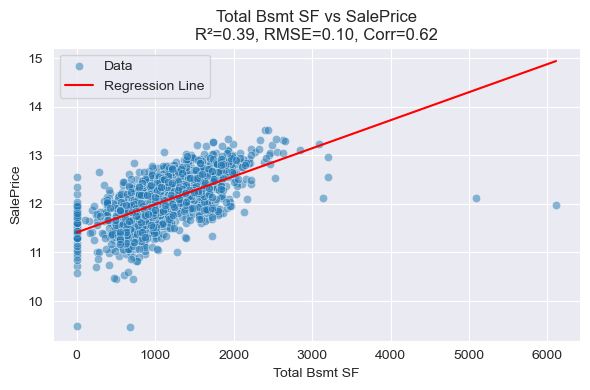

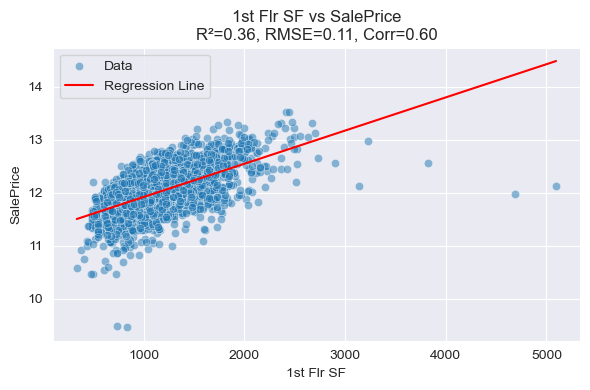

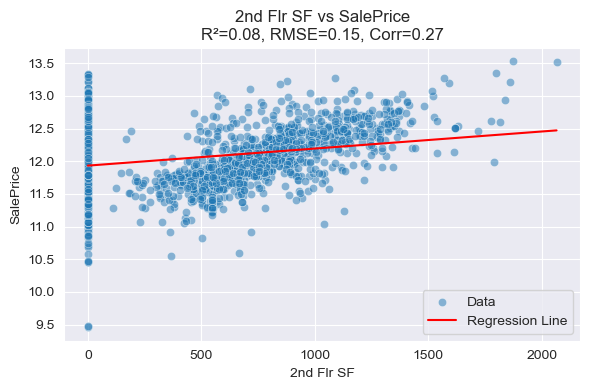

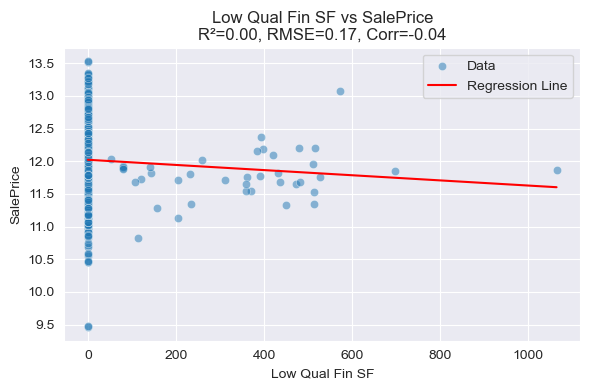

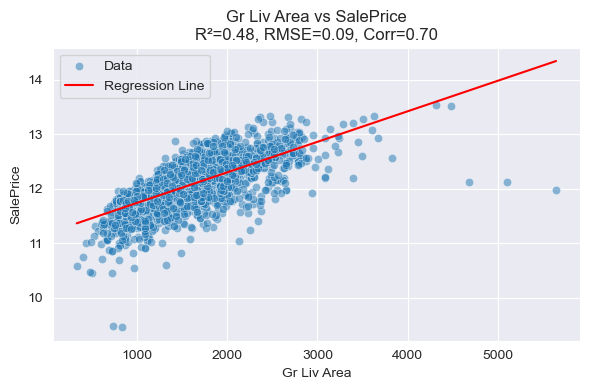

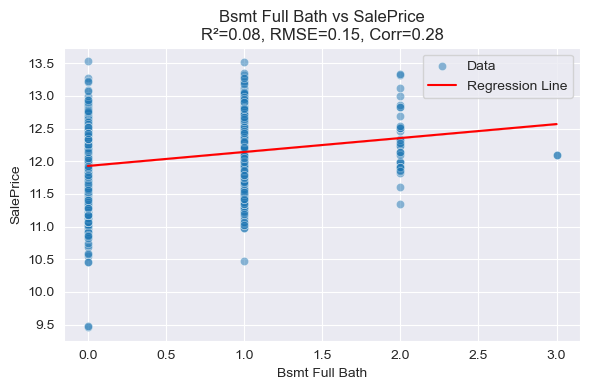

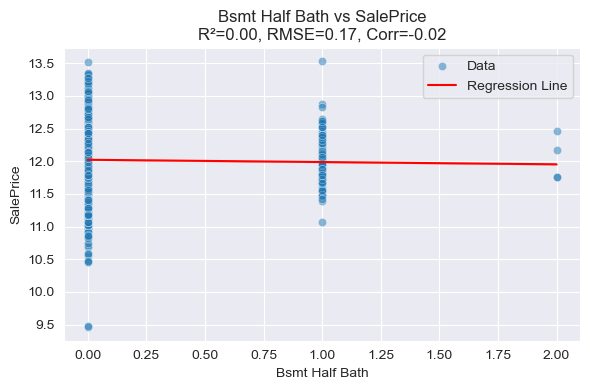

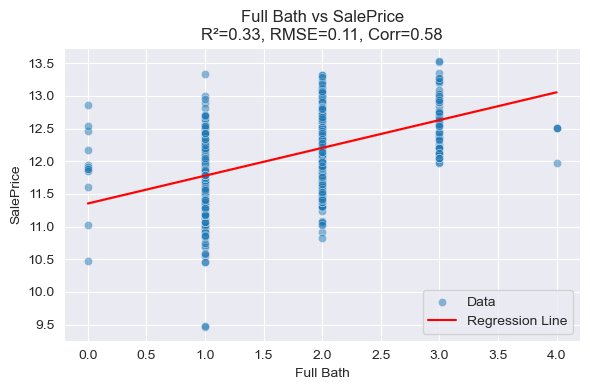

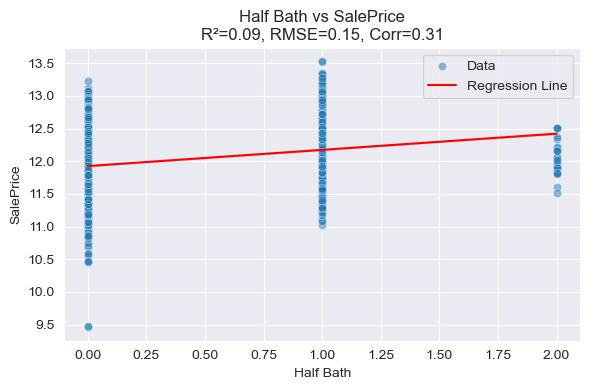

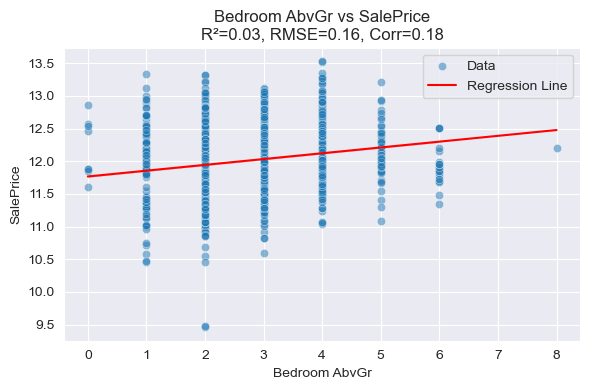

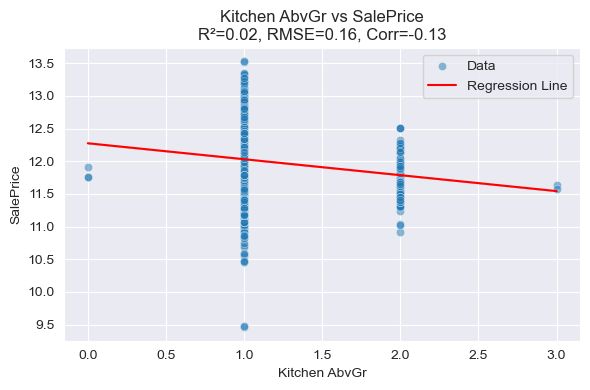

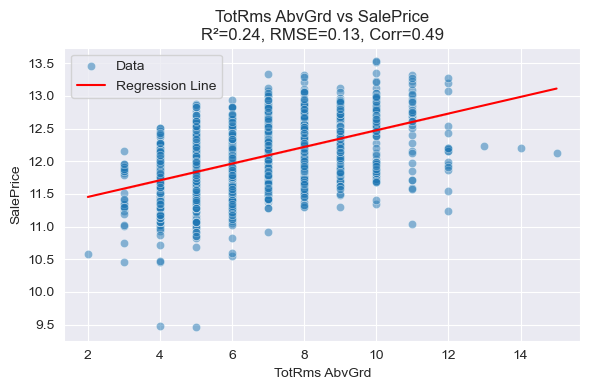

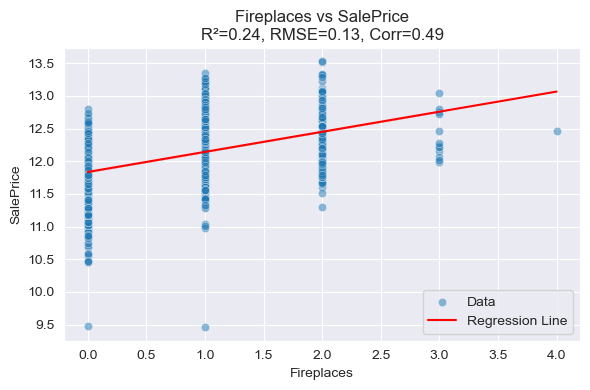

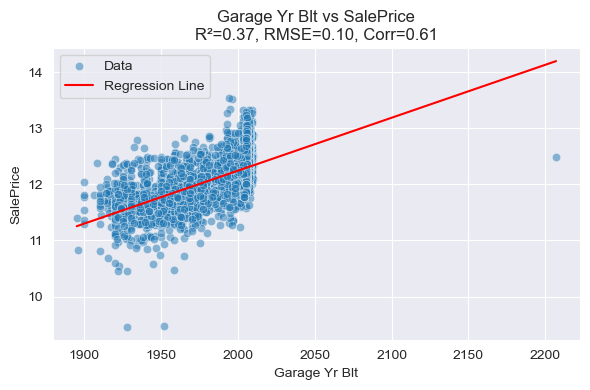

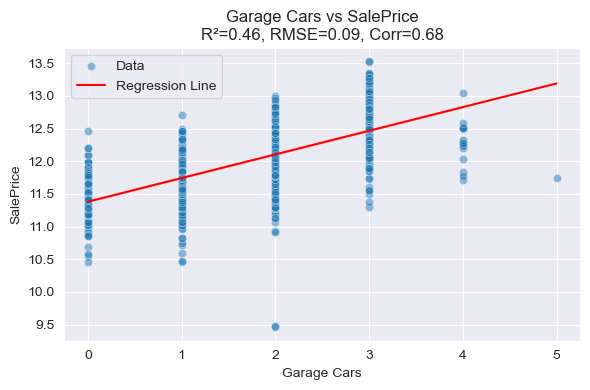

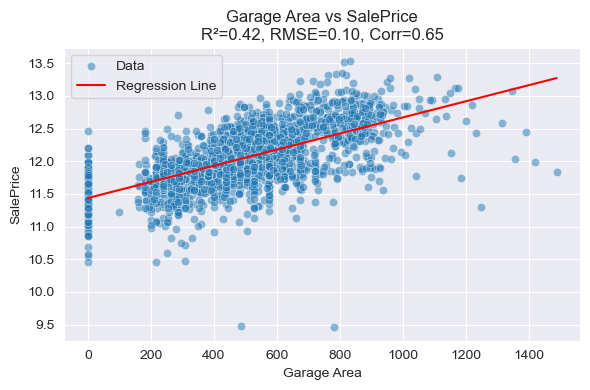

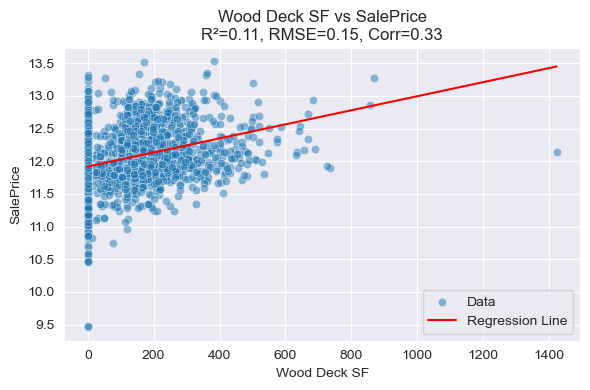

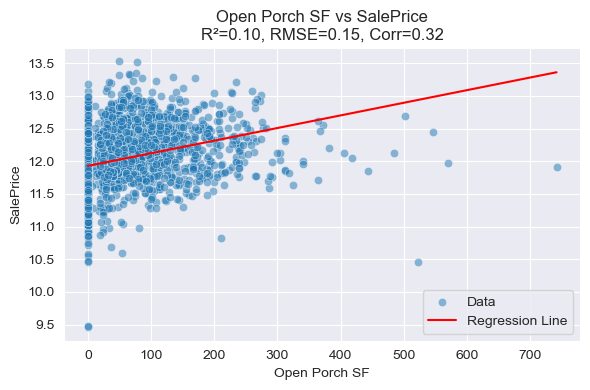

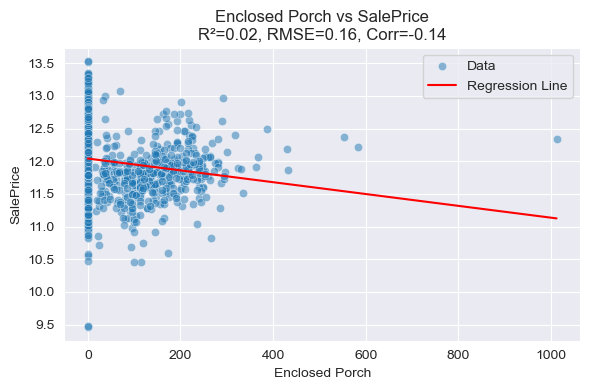

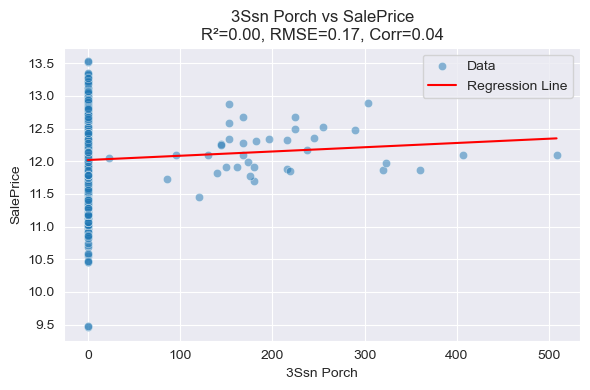

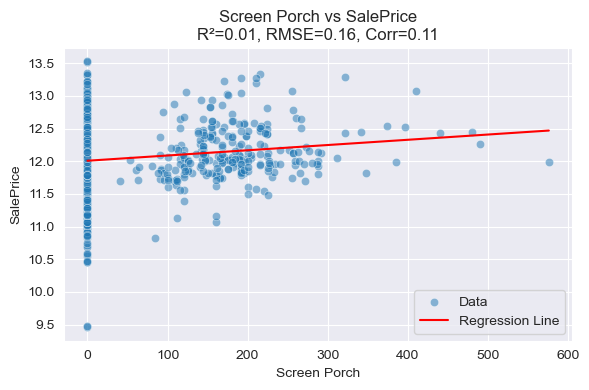

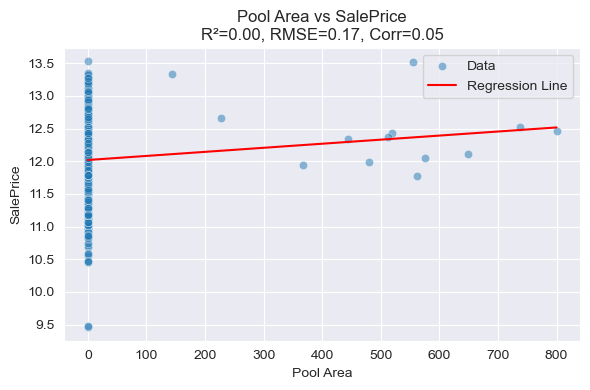

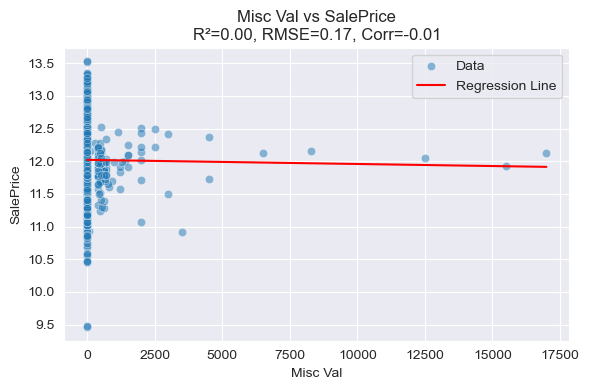

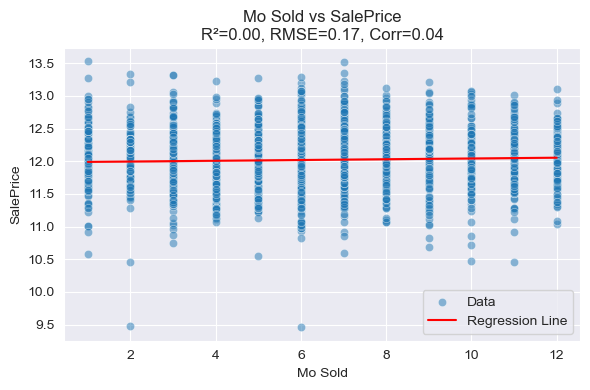

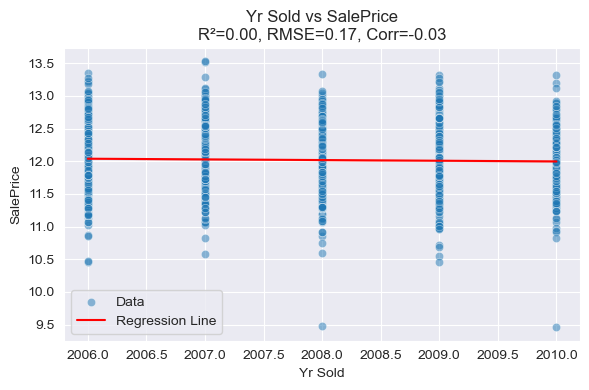

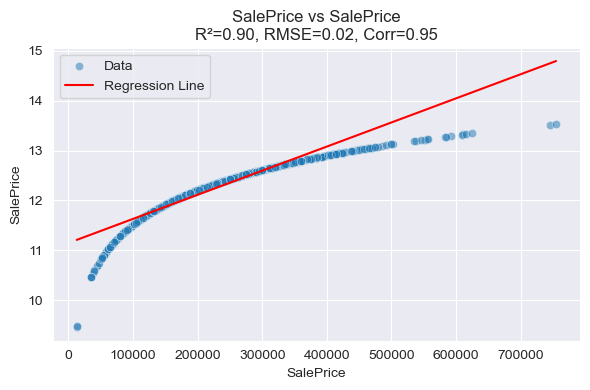

In [7]:
numeric_cols = edited_df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    
    X = edited_df[[col]]
    y = np.log1p(edited_df.loc[X.index, 'SalePrice'])
    
    
    # 회귀 모델 학습
    model = LinearRegression()
    model.fit(X, y)
    
    # 예측값
    y_pred = model.predict(X)
    
    corr = np.corrcoef(X[col], y)[0, 1]
    r2 = model.score(X, y)
    
    rmse = mean_squared_error(y, y_pred)
    
    # 시각화
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X[col], y=y, data=X, alpha=0.5, label='Data')
    sns.lineplot(x=X[col], y=y_pred, color='red', label='Regression Line')
    plt.title(f'{col} vs SalePrice\nR²={r2:.2f}, RMSE={rmse:.2f}, Corr={corr:.2f}')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

이상치 제거 X, 분포등을 고려하지 않고 선형회귀를 한 결과, 몇몇 그래프에서 이상 선형회귀 모델의 적합도가 많이 떨어지는 양상이 보인다. 이에 이상치 제거, 0이 다수인경우 제거하는 방법을 적용한 후 기존 그래프와 비교를 해본다.

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


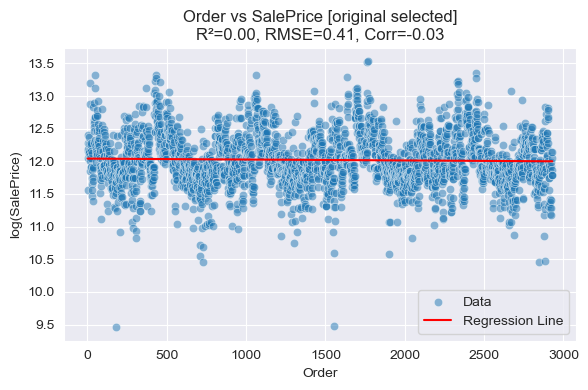

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


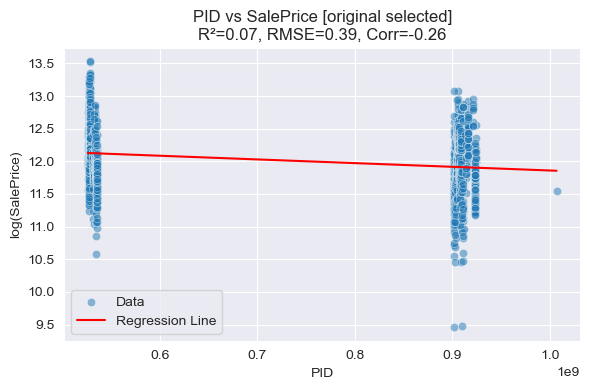

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


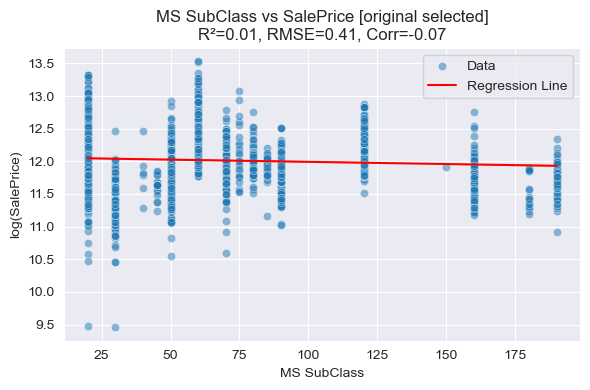

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


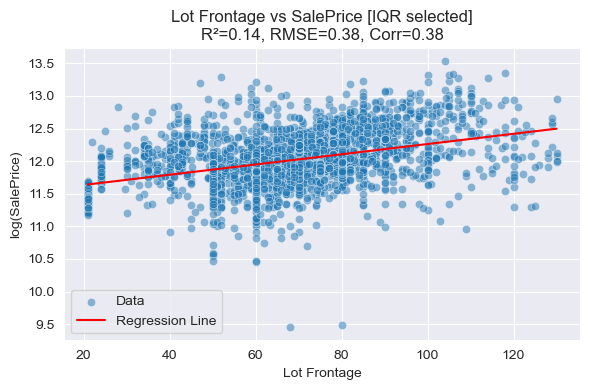

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


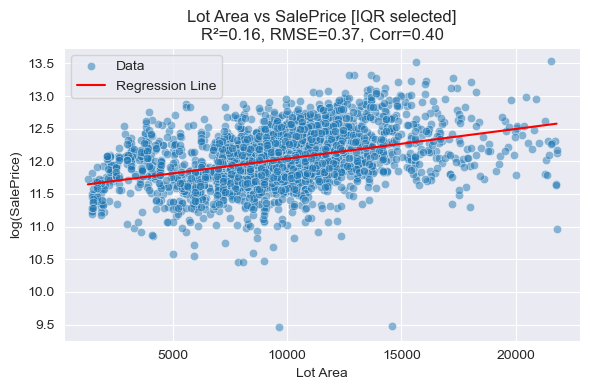

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


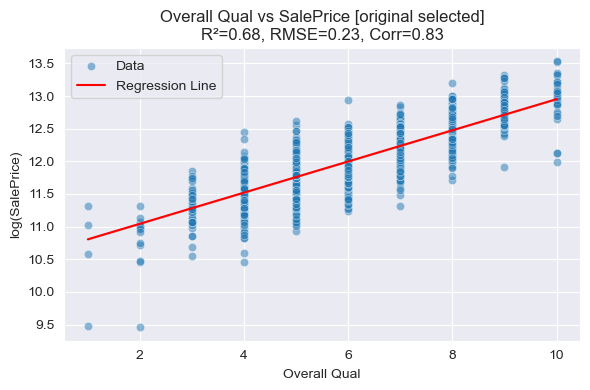

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


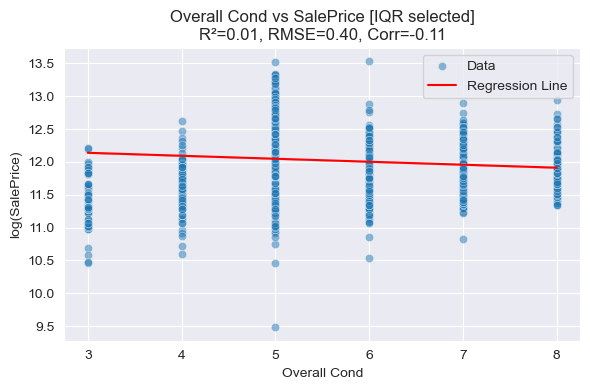

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


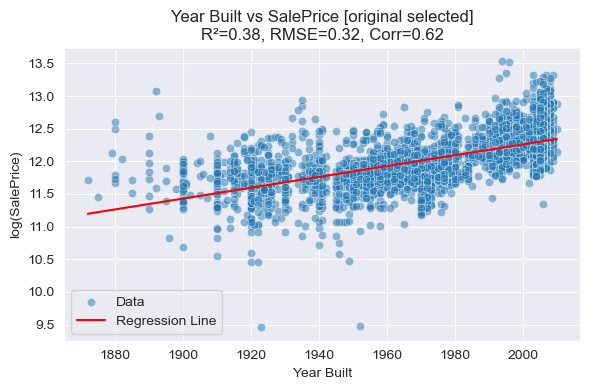

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


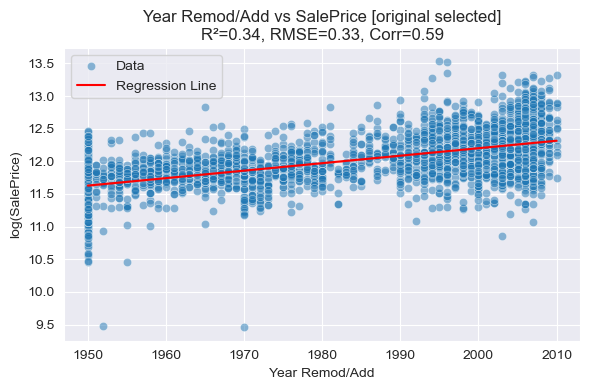

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


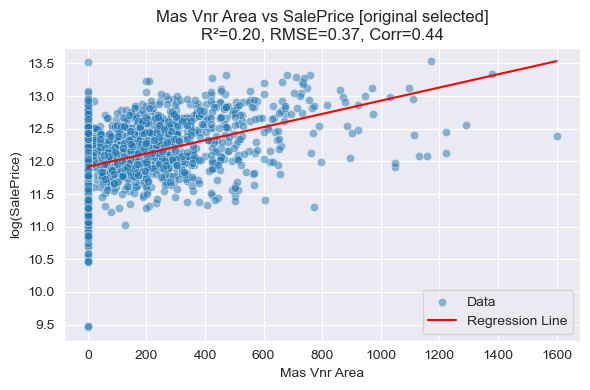

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


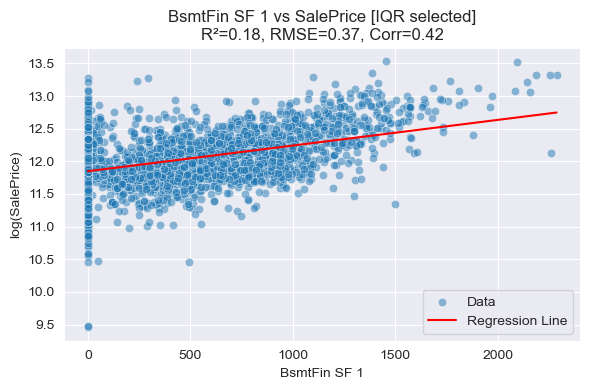

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


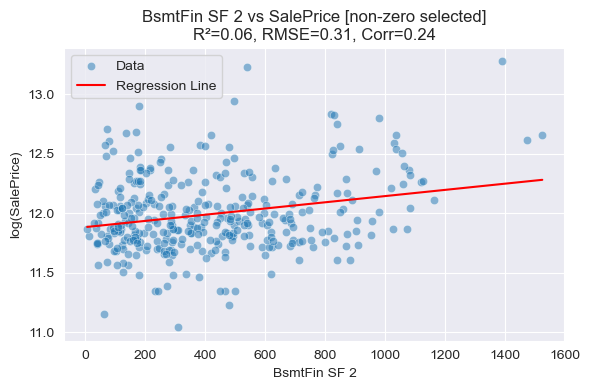

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


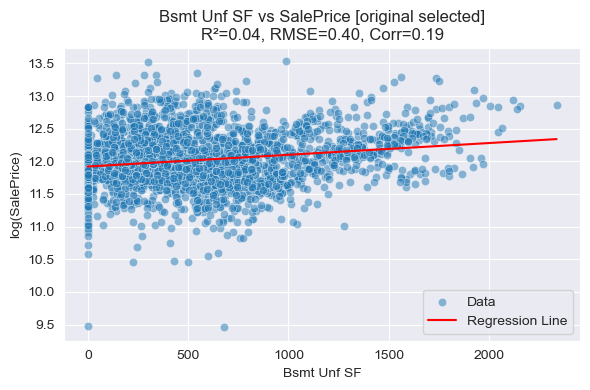

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


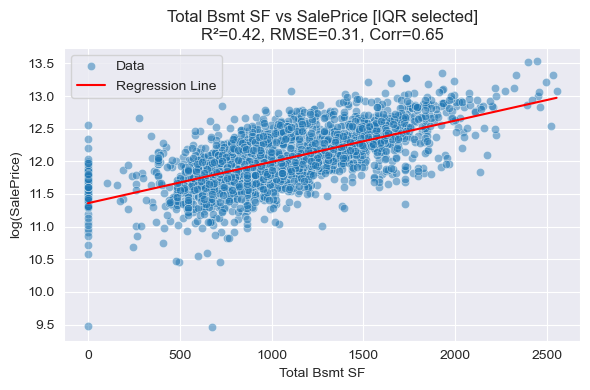

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


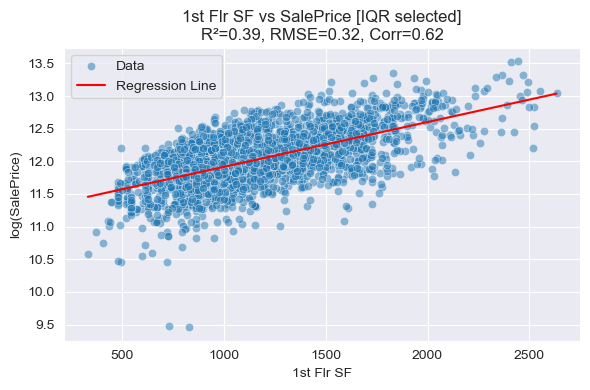

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


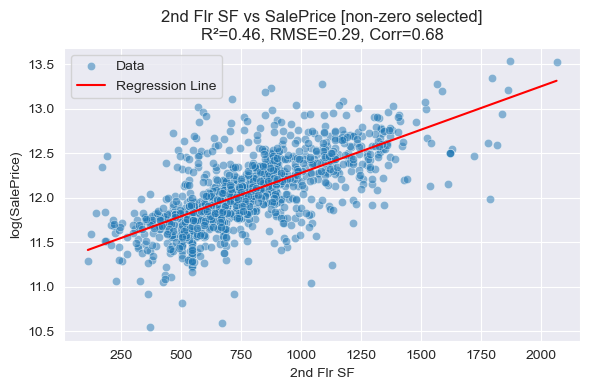

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


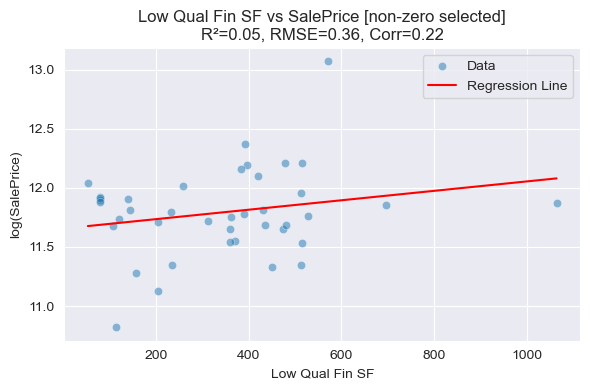

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


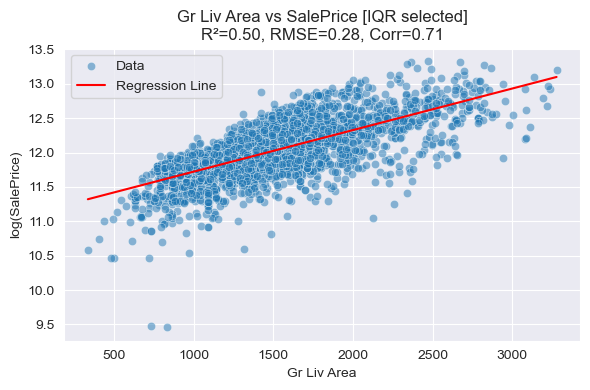

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


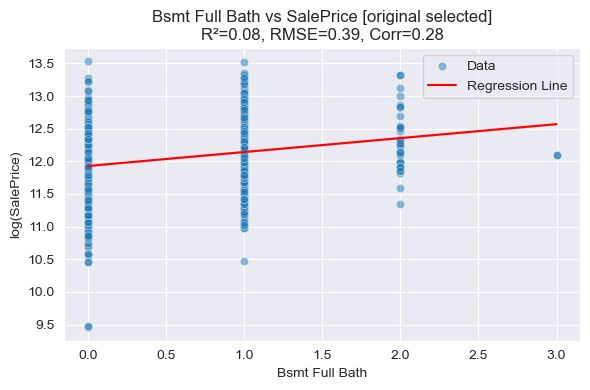

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


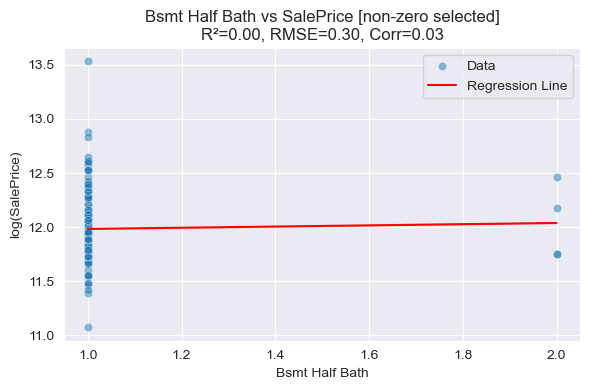

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


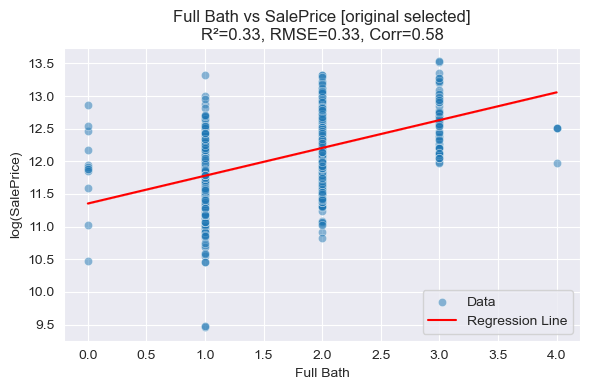

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


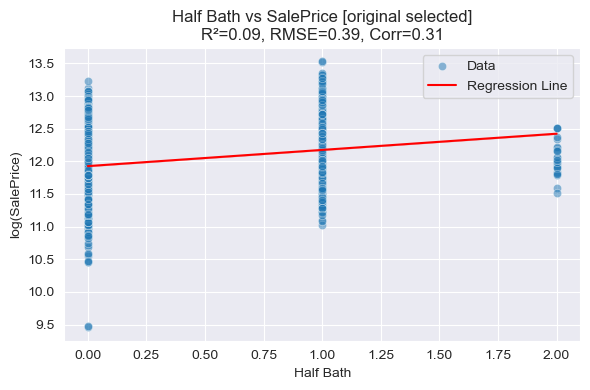

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


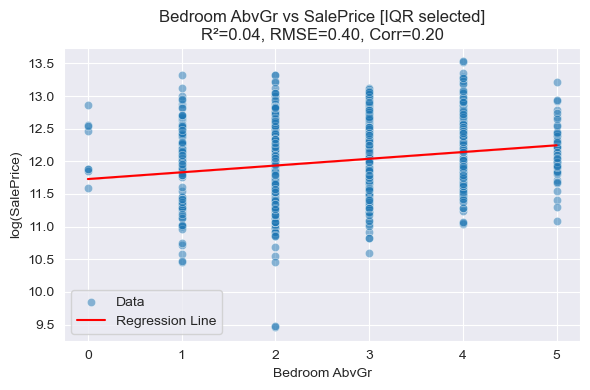

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


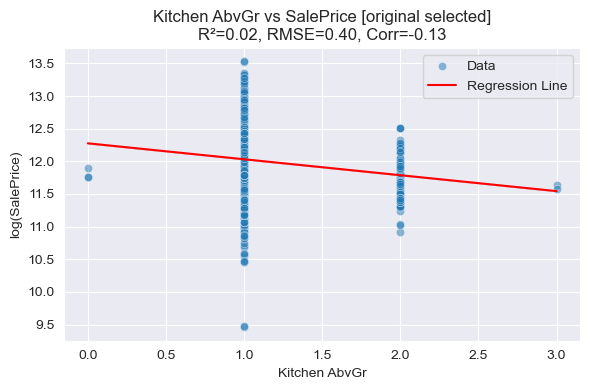

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


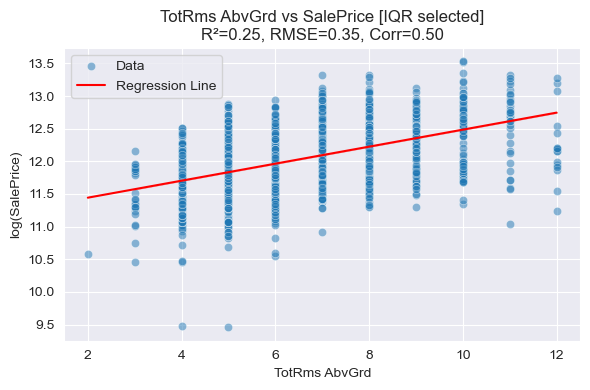

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


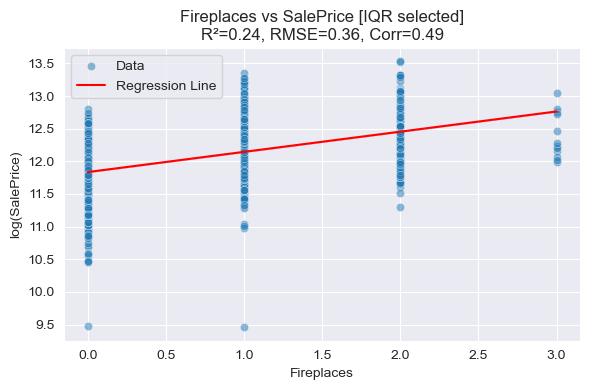

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


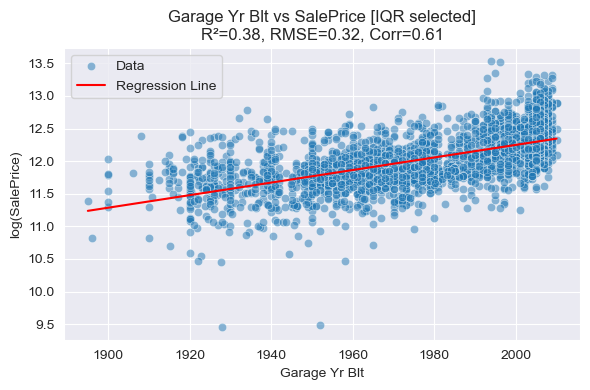

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


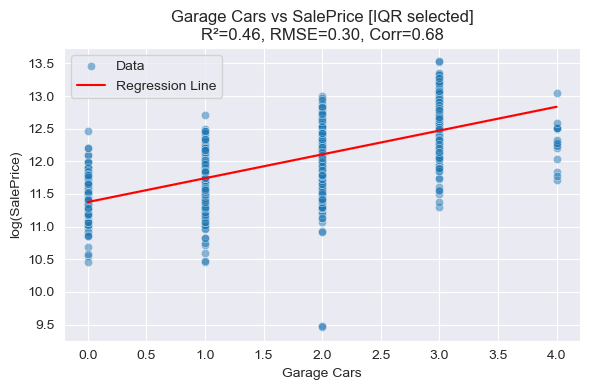

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


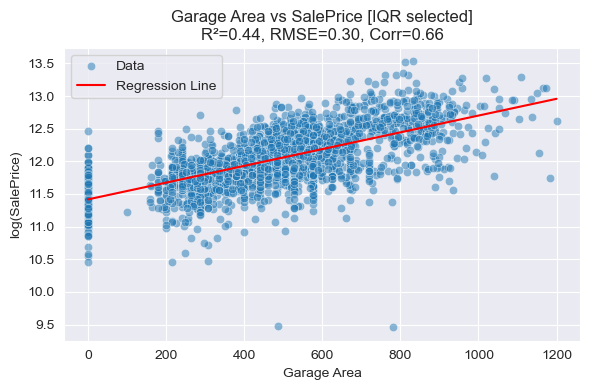

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


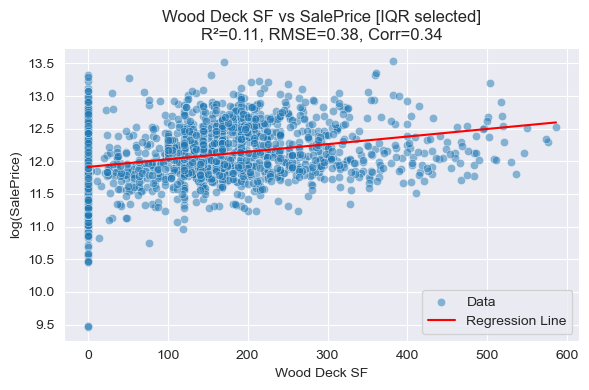

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


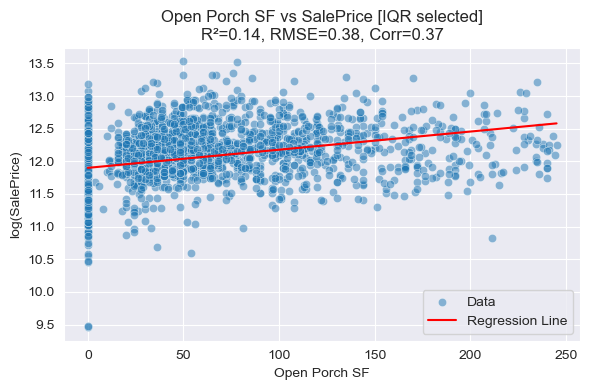

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


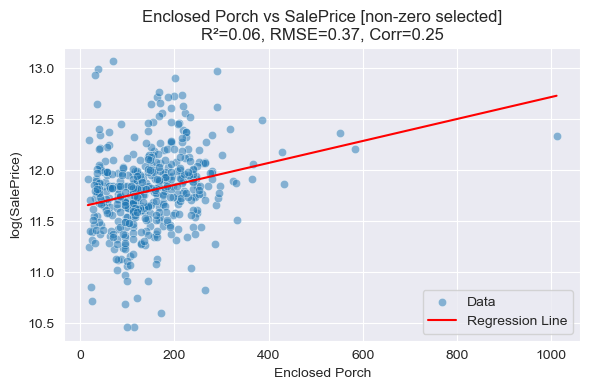

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


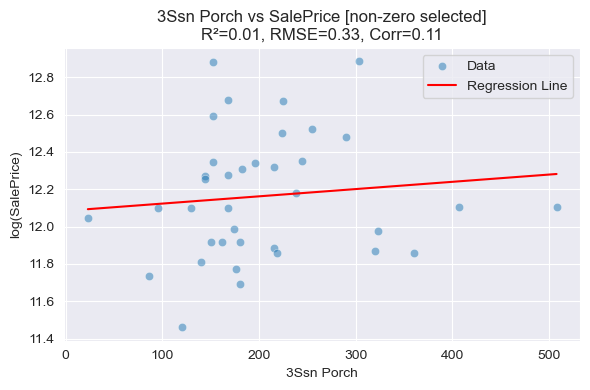

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


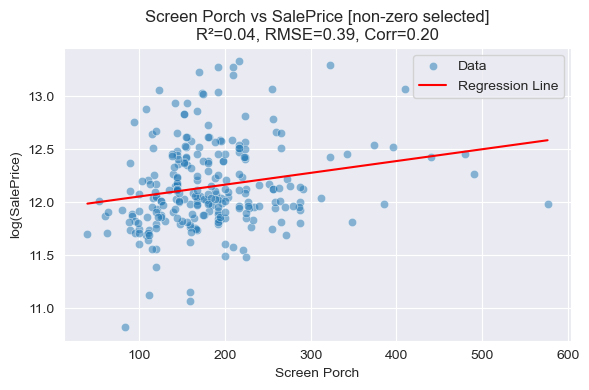

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


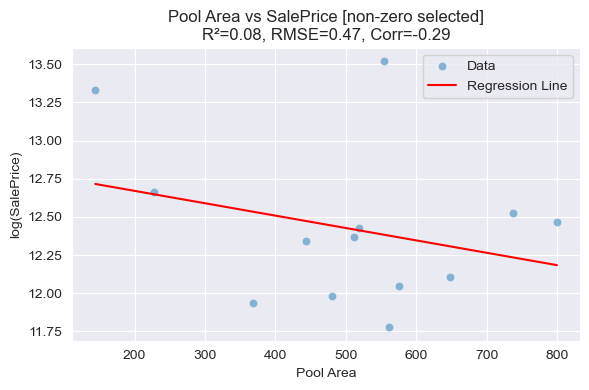

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dongbin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


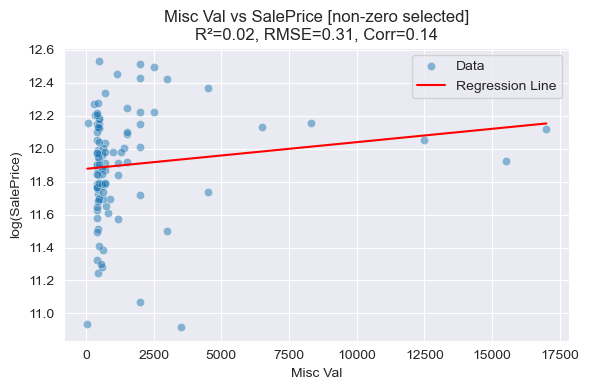

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


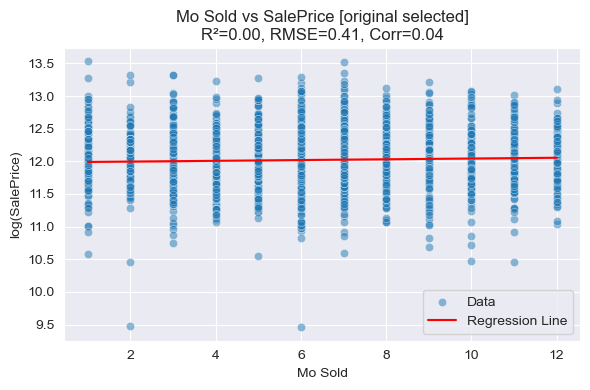

C:\Users\dongbin\AppData\Local\Temp\ipykernel_22540\48397459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['y'] = np.log1p(base_df['SalePrice'])


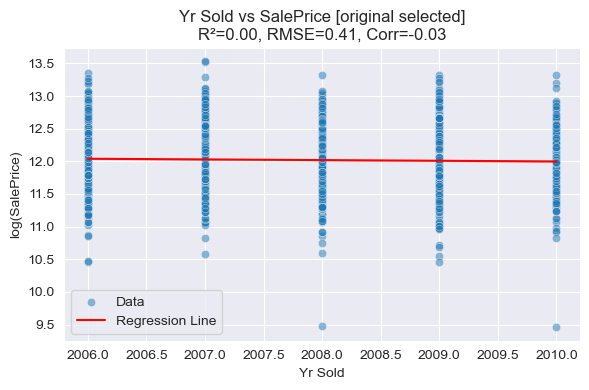

ValueError: Cannot set a DataFrame with multiple columns to the single column y

In [8]:
numeric_cols = edited_df.select_dtypes(include=['number']).columns

for col in numeric_cols:
    
    def train_and_evaluate(X, y):
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = model.score(X, y)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        corr = np.corrcoef(X.squeeze(), y)[0, 1]
        return r2, rmse, corr, y_pred
    
    base_df = edited_df[[col, 'SalePrice']]
    base_df['y'] = np.log1p(base_df['SalePrice'])
    base_X = base_df[[col]]
    base_y = base_df['y']
    r2_base, rmse_base, corr_base, y_pred_base = train_and_evaluate(base_X, base_y)

    
    # 이상치 제거 (IQR)
    Q1 = base_df[col].quantile(0.25)
    Q3 = base_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2.5 * IQR
    upper = Q3 + 2.5 * IQR
    iqr_df = base_df[(base_df[col] >= lower) & (base_df[col] <= upper)]
    r2_iqr, rmse_iqr, corr_iqr, y_pred_iqr = train_and_evaluate(iqr_df[[col]], iqr_df['y'])

    # 0 제거 (전체의 50% 이상이 0일 경우만 시도)
    zero_ratio = (base_df[col] == 0).mean()
    if zero_ratio > 0.5:
        nonzero_df = base_df[base_df[col] != 0]
        r2_nonzero, rmse_nonzero, corr_nonzero, y_pred_nonzero = train_and_evaluate(nonzero_df[[col]], nonzero_df['y'])
    else:
        r2_nonzero, rmse_nonzero, corr_nonzero, y_pred_nonzero = None, None, None, None
    
    # 가장 좋은 R² 기준 선택
    best_case = 'original'
    best_r2 = r2_base
    best_df = base_df
    best_y_pred = y_pred_base
    best_corr = corr_base
    best_rmse = rmse_base

    if r2_iqr > best_r2:
        best_case = 'IQR'
        best_r2 = r2_iqr
        best_df = iqr_df
        best_y_pred = y_pred_iqr
        best_corr = corr_iqr
        best_rmse = rmse_iqr

    if r2_nonzero and r2_nonzero > best_r2:
        best_case = 'non-zero'
        best_r2 = r2_nonzero
        best_df = nonzero_df
        best_y_pred = y_pred_nonzero
        best_corr = corr_nonzero
        best_rmse = rmse_nonzero
    
    # 시각화
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y='y', data=best_df, alpha=0.5, label='Data')
    sns.lineplot(x=best_df[col], y=best_y_pred, color='red', label='Regression Line')
    plt.title(f'{col} vs SalePrice [{best_case} selected]\nR²={best_r2:.2f}, RMSE={best_rmse:.2f}, Corr={best_corr:.2f}')
    plt.xlabel(col)
    plt.ylabel('log(SalePrice)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    